<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-07/W7_Tutorial_10_DLATK_extracting_correlating_topics_R_(dla_tutorial)_withSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W7 Tutorial 10 -- Extracting and Correlating Topics (DB: dla_tutorial) (2025-05)

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.


✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.


Let's set up Colab, as usual.

🚨🚨 In this tutorial, you need an updated `dlatk_lexica.db` file (with `w2v_2000`, `w2v_1000`, etc.). Check Slack!

## 1) Setting up Colab with DLATK and SQLite

In [ ]:
database="dla_tutorial"

### 1a) Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql

### 1b) Download the custom R script

This github repo contains our custom R script psych290RcodeV1.R (also copies of CSVs for dla_tutorial and other tutorials)!

In [ ]:
# this downloads the csvs & script we need for this tutorial
!git clone https://github.com/CompPsychology/psych290_data.git

💡 BTW, if you ever need a copy of psych290RcodeV1.R (RStudio at home!), you can download it here!

### 1c) Mount Google Drive and copy databases

Note: to do this tutorial, you will need a version of `dlatk_lexica.db` with `w2v_2000`, `w2v_1000`, etc.

In [ ]:
database="dla_tutorial"

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies dlatk_lexica.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/dlatk_lexica.db" "sqlite_data"

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

Mounted at /content/drive


### 1d) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

### 1e) (ONLY If nedded: SOFT RELOAD): If you have a **"database lock"** problem

If you face a "database locked" issue, restart the session (Runtime ==> Restart Session) & run this cell to get set back up!


In [ ]:
database = "dla_tutorial"

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

## 2) What is in `dlatk_lexica` topic tables?

There are two kinds of tables associated with a given "topic model":    
- $P(topic | word)$ - for a given word encountered in a 1gram, we get the mapping of that word to topics.
- $F(word | topic)$ - for a given topic, which words most constitute it -- are most prevalent within it.  

In this tutorial we'll be working with 2,000 FB topics used in a number of papers, freely available [here.](http://wwbp.org/data.html)  
If you want to make these tables from a dataset, Tutorial-11 on Topic modeling using [Mallet](http://mallet.cs.umass.edu/index.php) (which we have released along with this tutorial) should be helpful.

Let's look at the `dlatk_lexica` database to explore these FB topics.

### 2a) $P(topic|word)$ conditional probability table (`fb2000_cp`)

Since the conditional probability maps the words to topics, let's find the $P(topic|word)$ for the word `chicken`.

First, let's connect to the dlatk_lexica database and take a look at the tables.

In [ ]:
%sql dlatk_lexica_engine

In [ ]:
%sqlcmd tables

Great, now let's look in the conditional probability table!

In [ ]:
topics_cp_table = 'fb2000_cp'

In [ ]:
%%sql

SELECT *
FROM {{topics_cp_table}}
WHERE term = "chicken"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

id,term,category,weight
277318,chicken,1352,0.358016925892
150388,chicken,1115,0.213517840805
221983,chicken,1531,0.138180466606
186297,chicken,775,0.0980958371455
120718,chicken,788,0.0619853613907
822,chicken,341,0.0459457913998
275991,chicken,737,0.0305352241537
240817,chicken,39,0.0299919945105
16325,chicken,1174,0.0127516010979
122819,chicken,1371,0.00431724611162


This tell us which topics should get "credit" when `chicken` occurs in the text. One way in which we can convince ourselves is by confirming that the weights sum to one -- i.e., one `chicken` occurs at a time, and then it gets split up (sorry!).

In [ ]:
topics_cp_table = 'fb2000_cp'

In [ ]:
%%sql

SELECT SUM(weight)
FROM {{topics_cp_table}}
WHERE term = "chicken";

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

SUM(weight)
1.0000000000001863


This is 1 -- the sum is a bit more than `1.0` due to how the computer handles precision of floating points.

#### 👩‍🔬💻 Exercise

Try it out for another keyword! Say, `psychology`?

**Answer**

In [ ]:
topics_cp_table = 'fb2000_cp'

In [ ]:
%%sql

SELECT *
FROM {{topics_cp_table}}
WHERE term = "psychology"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

id,term,category,weight
88061,psychology,430,0.426311263972
305691,psychology,478,0.071883061049
145998,psychology,1037,0.0613929492691
116505,psychology,1927,0.0576096302666
183683,psychology,862,0.0564058469475
29142,psychology,244,0.0450558899398
135641,psychology,916,0.0388650042992
35751,psychology,1617,0.0369733447979
215079,psychology,1094,0.0349097162511
253843,psychology,87,0.0326741186586


In [ ]:
%%sql

SELECT SUM(weight)
FROM {{topics_cp_table}}
WHERE term = "psychology";

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

SUM(weight)
0.9999999999993652


### 2b) $F(word|topic)$ "frequency" table (`fb2000_freq_t50ll`)

The previous table told us how to distribute the occurences of a particular word among topics. This table tells us what a particular topic is made up of, by frequency -- which words actually determine a given topic. Let's look at topic `1352`, the one that got the highest `chicken` distribution above.

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT *
FROM {{topics_freq_table}}
WHERE category = "1352"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

id,term,category,weight
67091,chicken,1352,12522.0
67133,fried,1352,4321.0
67131,nuggets,1352,1254.0
67093,pickles,1352,1166.0
67088,kfc,1352,1162.0
67121,ate,1352,811.0
67083,deep,1352,800.0
67105,bbq,1352,768.0
67116,pickle,1352,755.0
67099,wings,1352,749.0


Turns out that this is really a "chicken" topic!

Let's compare this to the topic `1531`, which was the third highest weight for `chicken` in the conditional probability table above.

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT *
FROM {{topics_freq_table}}
WHERE category = "1531"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

id,term,category,weight
53630,dinner,1531,6391.0
53607,potatoes,1531,5179.0
53587,chicken,1531,4833.0
53671,beans,1531,3470.0
53611,steak,1531,3207.0
53614,pork,1531,2987.0
53681,potato,1531,2612.0
53676,mashed,1531,2531.0
53593,rice,1531,2493.0
53649,salad,1531,2476.0


This time it turns out that this is really a dinner topic, that `dinner` and `potatoes` are more prevalent within it.

Note that the frequency table doesn't sum to one.

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT SUM(weight)
FROM {{topics_freq_table}}
WHERE category = "1531"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

SUM(weight)
88768.0


This number means that during the modeling process, 88,768 token occurrence were mapped to this dinner topic.  

#### **Optional tidbit:**

If we wanted to turn this F(word | topic) table into an actual probability distribution for a topic P(word | topic), we would simply normalize it -- that is, divide the weights within the topic by the _sum_ of the weights within the topic.

We don't have to do this as we are generally interested in the rank order of the frequencies with which words were assigned to a topic -- what's currently in the `weights` column. For completeness, let's simply divide the weight by the sum of weights obtained above to sum it to one.

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT SUM(n_weight)
FROM (SELECT id, term, category, weight*1.0 / 88768 AS n_weight
      FROM {{topics_freq_table}}
      WHERE category = "1531") AS n_table;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

SUM(n_weight)
1.0000000000000002


Now these weights, too, would add to 1!! (we don't need this going forward -- just FYI -- now it would be a proper P(word | topic).)

### 2c) Top words for given topics

Sometimes you just want the top 10 words for some (or all topics) in an easy way, say because you want to import them into R to label your topics.

We can do that with some heavy SQL that you should just copy and paste and modify when you need it. Let's get the top 10 words for the top 3 topics that `chicken` was mapped to (`HAVING category LIKE "1352" OR category LIKE "1115"  OR category LIKE "1531";`)

**NOTE:** This uses a Common Table Expression (CTE) and a window function (`PARTITION`) in SQL. You don't need to know this -- just copy and mod the query whenever you need it.

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10 # THIS SETS THE NUMBER OF WORDS PER TOPIC
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING category LIKE '1352' OR category LIKE '1115' OR category LIKE '1531'; # THIS SETS THE CHOICE OF TOPICS

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

category,top_words
1115,"soup, chicken, making, noodles, eating, noodle, dinner, ramen, homemade, lunch"
1352,"chicken, fried, nuggets, pickles, kfc, ate, deep, bbq, pickle, wings"
1531,"dinner, potatoes, chicken, beans, steak, pork, potato, mashed, rice, salad"


**NOTE:** This uses variables in 🐬 MySQL. They are denoted by the dollar sign. you don't need to know this -- just copy and mod the query whenever you need it.

```
🐬🐬🐬
SET @num := 0, @type := '';

SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {{topics_freq_table}}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10 #THIS SETS THE NUMBER OF WORDS PER TOPIC
GROUP BY category
HAVING category LIKE "1352" OR category LIKE "1115"  OR category LIKE "1531"; # THIS SETS THE CHOICE OF TOPICS
🐬🐬🐬
```

### 2d) Top words for topics containing a keyword

Sometimes we'd like to see all the topics that contain a keyword among their top `k` words (where k = 10 is reasonable). For example, to show all the topics containing `chicken` among the top 10, see below.

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10 # THIS SETS THE NUMBER OF WORDS PER TOPIC
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING top_words LIKE "%chicken%"; # THIS SETS A KEYWORD

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

category,top_words
1115,"soup, chicken, making, noodles, eating, noodle, dinner, ramen, homemade, lunch"
1352,"chicken, fried, nuggets, pickles, kfc, ate, deep, bbq, pickle, wings"
1531,"dinner, potatoes, chicken, beans, steak, pork, potato, mashed, rice, salad"
341,"barn, friend, raising, chicken, read, click, farmville, terms, offensive, helped"
775,"sauce, chicken, salad, cheese, garlic, dinner, bread, pasta, tomato, pepper"
788,"yum, dinner, crab, rice, curry, chicken, shrimp, eating, yummy, lunch"


```
🐬🐬🐬
SET @num := 0, @type := '';
SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {topics_freq_table}
      ORDER BY category, weight DESC) AS x #THIS SETS THE NUMBER OF WORDS PER TOPIC
WHERE x.row_number <= 10
GROUP BY category
HAVING top_words LIKE "%chicken%"; # THIS SETS A KEYWORD
🐬🐬🐬
```

#### 👩‍🔬💻 Exercise

Can you find all topics that have `sleep` among the top 5 words using the above query? `sleep` is used more than `chicken`, so it it also appears in more topics.

**Answer**

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10 # THIS SETS THE NUMBER OF WORDS PER TOPIC
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING top_words LIKE '%sleep%'; # THIS SETS A KEYWORD

```
🐬🐬🐬
SET @num := 0, @type := '';
SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {topics_freq_table}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10
GROUP BY category
HAVING top_words LIKE "%sleep%";
🐬🐬🐬
```

## 3) Topic wordclouds

Now, let's produce topic wordclouds from the `topics_freq_table` -- F(word | topic) -- similar to what we did for 1-gram, and LIWC correlations, etc. -- using DLATK, rather than as a list of words above.

**FYI:** ⏰ This will take a ~15 minutes as it goes over all 2000 topics.

💡 Before that, let's re-initialize the connection to our `dla_tutorial` database!

In [ ]:
%sql tutorial_db_engine

In [ ]:
database='dla_tutorial'
msgs_table = 'msgs'

topics_freq_table = 'fb2000_freq_t50ll'

OUTPUT_FOLDER = './output_tutorial_10/topic_wordclouds'
OUTPUT_NAME = 'output'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --topic_lexicon {topics_freq_table} \
    --group_freq_thresh 500 \
    --make_all_topic_wordclouds \
    --tagcloud_colorscheme blue \
    --output {OUTPUT_FOLDER}/{OUTPUT_NAME}



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-14 02:18:41
-----
Connecting to SQLite database: /content/sqlite_data/dla_tutorial
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_10/topic_wordclouds/output_alltopics/topic_0_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_10/topic_wordclouds/output_alltopics/topic_1_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_10/topic_wordclouds/output_alltopics/topic_10_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_10/topic_wordclouds/output_alltopics/topic_100_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_10/topic_wordclouds/output_alltopics/topic_1000_wc.png
Generating wordclouds using amueller's python pa

The above command produced files into `./output_tutorial_10/topic_wordclouds`. There should be 2 files per topic -- a png and a txt file.

In [ ]:
!ls {OUTPUT_FOLDER}/{OUTPUT_NAME}* | wc -l

2000


So, that's 2 files for 2000 topics as in the image. You can copy the word clouds from Colab to your Google Drive as usual (see bottom of tutorial!).

Here are the word clouds for the `chicken` topics (category like `1352` or category like `1115` or category like `1531`). Note that it's exactly what we see above in the above SQL sections).

<img src="https://raw.githubusercontent.com/CompPsychology/psych290_images/main/images/tutorial-10/fig2.png" width="1000">

## 4) Extracting topics for a `--correl_field` group

All the conceptual complexity aside, once a topic table is in DLATK, it just behaves like a weighted dictionary (remember `labmt` and `nrc`?) -- and is extracted extracted exactly like them. Let's do that.

### 4a) Making sure we have a user 1gram table

We always first need to extract a 1gram table -- that's always the case with dictionaries, weighted or not. We will extract topics from the `msgs` table in our usual 'dla_tutorial' database for user_id's.

Here we extract the 1-grams, **if needed.**

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'

In [ ]:
# Here we extract the 1-grams IF NEEDED
# !dlatkInterface.py \
#     --corpdb {database} \
#     --corptable {msgs_table} \
#     --correl_field user_id \
#     --add_ngrams -n 1

The above command produced table `feat$1gram$msgs$user_id`. Same as always.



### 4b) Extracting Topics

Once we have the 1gram table, we can extract the topic features. To extract topics for groups, we just need to use `--add_lex_table {topic_cp_table} --weighted_lexicon` (since it's a weighted lexicon -- it has weights we need to consider).

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
topics_cp_table = 'fb2000_cp'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --group_freq_thresh 500 \
    --add_lex_table -l {topics_cp_table} \
    --weighted_lexicon




-----
DLATK Interface Initiated: 2025-05-14 22:46:12
-----
Connecting to SQLite database: /content/sqlite_data/dla_tutorial
query: PRAGMA table_info(msgs)
SQL Query: DROP TABLE IF EXISTS feat$cat_fb2000_cp_w$msgs$user_id$1gra
SQL Query: CREATE TABLE feat$cat_fb2000_cp_w$msgs$user_id$1gra ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(10), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$cat_fb2000_cp_w$msgs$user_id$1gra, column:group_id 


SQL Query: CREATE INDEX correl_field$cat_fb2000_cp_w$msgs$user_id$1gra ON feat$cat_fb2000_cp_w$msgs$user_id$1gra (group_id)


Creating index feature on table:feat$cat_fb2000_cp_w$msgs$user_id$1gra, column:feat 


SQL Query: CREATE INDEX feature$cat_fb2000_cp_w$msgs$user_id$1gra ON feat$cat_fb2000_cp_w$msgs$user_id$1gra (feat)
WORD TABLE feat$1gram$msgs$user_id
10 out of 1000 group Id's processed; 0.01 complete
20 out of 1000 group Id's processed; 0.02 complete
30 out of 1000 group Id's processed; 0.03 complet

The above command created the topic feature table `feat$cat_fb2000_cp_w$msgs$user_id$1gra`. You will recognize the `_w` as being the result of `--weighted_lexicon`.


### 4c) Exploring topic feature tables

Let's see some random features first:

In [ ]:
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

In [ ]:
%%sql

SELECT *
FROM {{feat_topics_table}}
ORDER BY RANDOM()
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

id,group_id,feat,value,group_norm
1240476,3832385,1698,24,0.0008861013265320277
1347654,3893150,1706,2,1.8676911359072537e-06
771735,3524887,680,37,0.00012733513569038857
1799696,4188004,1654,15,9.535023533976126e-05
674711,3471937,1551,107,0.00011327411517751272
1206232,3818197,1259,37,5.4517922945796734e-05
454001,3331655,761,1,1.0523766453211844e-07
657774,3466592,1125,25,0.0001155011223802845
14343,477665,488,237,9.28671046238924e-05
1388392,3929371,156,6,0.0005730250153101559


To belabor the point: In the topics cp table, topics are contained in the category field and stored as topic ids (numbers). These numbers (topic_ids) have become the content of the `feat` column here--this table captures how much different users express the different topics.

#### Out of curiosity: What do topic `group_norm`s sum to for users?

Let's see in SQL what the range of sums is. Careful to exclude the intercept by including all features except (!=) the intercept

In [ ]:
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

In [ ]:
%%sql

SELECT MIN(group_norm_sum), AVG(group_norm_sum), MAX(group_norm_sum)
FROM (SELECT SUM(group_norm) AS group_norm_sum
      FROM {{feat_topics_table}}
      WHERE feat != "_intercept"
      GROUP BY group_id) AS a ;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

MIN(group_norm_sum),AVG(group_norm_sum),MAX(group_norm_sum)
0.022692889561272498,0.2634539198114946,0.3912310286678045


So they don't sum to one for the users. Let's plot this in R. For more R guidance, see the last section below. Here we use the function `importTopicFeat()` to get a wide topic dataframe from the long feat table that DLATK produces.

But before that load the `%%R` line magic and set up really quick!

In [ ]:
%load_ext rpy2.ipython

Now install packages (the fast way!) 🤓

In [ ]:
# this is equivalent to install.packages() but much faster!!
!apt-get update -qq
!apt-get install -y r-cran-rsqlite r-cran-ggthemes r-cran-reshape2 r-cran-psych

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-cran-reshape2 is already the newest version (1.4.4-2build1).
r-cran-rsqlite is already the newest version (2.3.11-1.ca2204.1).
r-cran-ggthemes is already the newest version (5.1.0-1.ca2204.1).
The following additional packages will be installed:
  r-cran-gparotation r-cran-mnormt
Suggested packages:
  r-cran-psychtools r-cran-lavaan r-cran-lme4 r-cran-rcsdp r-bioc-graph
  r-bioc-rgraphviz
The following NEW packages will be installed:
  r-cran-gparotation r-cran-mnormt r-cran-psych
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,229 kB of archives.
After this operation, 4,883 kB of additional disk space will be used.
Get:1 https://r2u.stat.illinois.edu/ubuntu jammy/main all 

Construct the database path, so RSQLite knows where to look!

In [ ]:
# constructs the pathname
database_path = f"sqlite_data/{database}.db"
database_path

'sqlite_data/dla_tutorial.db'

Setup cell!

☝🏻 Remember the `-i variable` is how you pass a Python variable into the R space!

In [ ]:
%%R  -i database_path

# load packages
library(tidyverse)
library(ggthemes)
library(reshape2)
library(psych)

# the custom R functions we have written to work with DLATK
source('./psych290_data/helper_files/psych290RcodeV1.R')

# load DBI for generic database functions and RSQLite as the SQLite backend
library(DBI)
library(RSQLite)

# connects to a file-based sqlite DB
db_con <- dbConnect(RSQLite::SQLite(),
                    dbname = database_path)

# enforce UTF-8 encoding
dbExecute(db_con, "PRAGMA encoding = 'UTF-8';")

[1] 0



Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



Now the plot!

[1] "SELECT sum(group_norm) as group_norm_sum FROM feat$cat_fb2000_cp_w$msgs$user_id$1gra WHERE feat != \"_intercept\" group by group_id"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In addition: Warning messages:
1: `qplot()` was deprecated in ggplot2 3.4.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


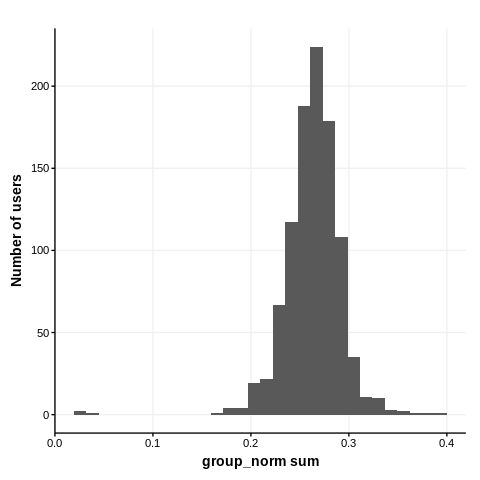

In [ ]:
%%R -i feat_topics_table

# define your query
query <- sprintf(
    'SELECT sum(group_norm) as group_norm_sum FROM %s WHERE feat != "_intercept" group by group_id',
    feat_topics_table) # the %s inserts the variable stored in feat_topics_table in that position it the string...

print(query) # ... so you can see in this output

# then you plot!
group_norm_sums <- dbGetQuery(db_con, query)

qplot(group_norm_sums$group_norm_sum) +
theme_Publication() +
ylab("Number of users") +
xlab("group_norm sum")

Let's look at the summary of our result.

In [ ]:
%R describe(group_norm_sums)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
group_norm_sum,1.0,1000.0,0.263454,0.028729,0.26457,0.264226,0.022758,0.022693,0.391231,0.368538,-1.439771,13.006664,0.000909


So they sum to 0.26 +/- 0.03.

They are *not* normalized for users, they are normalized for words, so that all P(topic | word) for a given WORD sum to one.

The topics were also modeled on a different corpus than the one they extracted on here -- the topics may miss language use observed in this dataset not seen in the original Facebook corpus that was the source for the 2,000 topics. And of course, topics miss stop words.

#### 👩‍🔬💻 Exercise

Does every user have all topics? Can you check with SQL?

**Answer:**

In [ ]:
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

In [ ]:
%%sql

SELECT count(distinct(feat)) AS num_topics
FROM {{feat_topics_table}}
GROUP by group_id
ORDER BY RANDOM()
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

num_topics
1994
1997
1996
1996
1961
1941
1972
1999
1959
1902


Ok, we see that they don't -- but almost. That means that some users didn't have a single word in some (presumably obscure) topics. That can happen as the topics were modeled on a different, much larger dataset.

The tail of the Zipfian distribution is long and full of wonder...

#### 👩‍🔬💻 Exercise

Can you think of the command to see who in our dataset talked the most about that chicken dinner topic (topic category = `1352`). (Check your understanding -- in the feature table, where are the names of the topic ids saved?)

**Answer:**

In [ ]:
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

In [ ]:
%%sql

SELECT *
FROM {{feat_topics_table}}
WHERE feat LIKE "1352"
ORDER BY group_norm DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

id,group_id,feat,value,group_norm
1127437,3759312,1352,18,0.0017994933227118435
1350575,3893735,1352,10,0.001245661620170448
1813714,4200075,1352,32,0.0012051619467495335
453195,3331655,1352,17,0.0010197089434149206
407914,3306195,1352,25,0.0009217756083307519
1786535,4179297,1352,22,0.0009118961813555566
425016,3319097,1352,430,0.0009056454503110077
1404654,3948533,1352,48,0.0008720276625493149
1824971,4206637,1352,17,0.0007964304185017554
608804,3431501,1352,36,0.000787792233599008


From the first entry, we see that the topic `1352` made up only `0.18%` of the language even for the user who was most into the chicken thing (group_id = here: user_id \[see table name\] = `3759312`).

## 💻 Worked example: which topic is the most popular, v2?

Can you think of the SQL command to see which was the most popular topic overall using the feature table? We saw above that not all users have all topics, so we need to normalize this "the right way" -- sum group_norms for a topic, divide by the total number of topics. (you can ignore `_intercept` in the output -- every user gets one).

In [ ]:
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

In [ ]:
%%sql

SELECT COUNT(DISTINCT feat)
FROM {{feat_topics_table}};

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

COUNT(DISTINCT feat)
2001


In [ ]:
%%sql

SELECT feat, SUM(group_norm)/2000 AS popularity
FROM {{feat_topics_table}}
GROUP BY feat
ORDER BY popularity DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

feat,popularity
_intercept,0.5
1686,0.0002973084526174627
1285,0.00028692838123262857
1990,0.00023202064952356936
285,0.00022430406205232296
62,0.0002229956575244421
1,0.00021774618905070903
1710,0.00021421984845047655
387,0.00021348570279316082
1895,0.0002122287201868357


We ignore `_intercept`, seems like topics `1686`, `1285`, and `1990` are the most popular, by relative frequency. Let's see which words they constitute, using the magic SQL query in 2c)

In [ ]:
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING category LIKE '1686' OR category LIKE '1285' OR category LIKE '1990';

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

category,top_words
1285,":/, http, www, blog, check, bible, org, net, html, link"
1686,"writing, write, read, story, poetry, poem, wrote, book, reading, stories"
1990,"site, online, page, website, called, fb, web, remove, posted, information"


```
🐬🐬🐬
SET @num := 0, @type := '';

SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM dlatk_lexica.{topics_freq_table}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10
GROUP BY category
HAVING category LIKE "1285" OR category LIKE "1686"  OR category LIKE "1990";
🐬🐬🐬
```

Ah, Ok, looks like weblinks are the most frequent semantic cluster. Duhhh! Ok, at least the world makes sense -- it's different kind of "speech act".


## 5) Correlating Topics

Correlating topics with outcomes isn't that different than correlating outcomes with any feature table.

Here is a generic correlate with feature table example, this is similar to what we did with LIWC, NRC, LabMT as feature tables. This will produce a CSV file and an HTML file.

You can run this if you wish (but also just look over).

In [ ]:
OUTPUT_FOLDER = './output_tutorial_10'
OUTPUT_NAME = 'topics_age_gender'
feat_fbtopics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --correlate \
    --rmatrix --csv \
    --group_freq_thresh 500 \
    --outcome_table {outcomes_table} \
    --outcomes age gender \
    --feat_table '{feat_fbtopics_user}' \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/logs.txt 2>&1

Note that this correlated the 2001 (minus intercept = 2000) features for the 978 users with more than 500 tokens.

output: `Yielding norms with zeros (978 groups * 2001 feats)`

Ok cool.

But now, we want to add the word cloud visualizations, like we did in previous tutorials -- but here using commands appropriate for topics. We will have to specify the `fb2000_freq_t50ll` table, so the topic word clouds can be made showing words by pravelence.

```
    --topic_tagcloud --make_topic_wordclouds \
    --topic_lexicon fb2000_freq_t50ll \
    --tagcloud_colorscheme blue
```
In these wordclouds, the color (here: shade of blue) is random, so that the words are visually easier to distinguish. Words are shown in descending "prevalence" -- weight in the $F(word|topic)$ "frequency" / `_freq` table.  Here is the prevalence topic legend, which you can reuse when layouting your own figures with topics. It's also in the powerpoint figure template.


<img src="https://raw.githubusercontent.com/CompPsychology/psych290_images/main/images/tutorial-10/fig3.png" width="200">

<h2> 🤓🥳

BTW, you have some other options for `--tagcloud_colorscheme` including `red`, `blue`, `redblue` and `bluered`. Default is `multi` (same as you saw in 1to3gram word clouds, but for topics colors would be random -- hence confusing not recommended).

bluered prints positively correlated clouds as blue and negatively correlated clouds as red, similarly, redblue prints positively correlated clouds as red and negatively correlated clouds as blue.


So let's put this all together, and get topic correlations with age and gender + topic clouds.

BTW, the word-cloud making will take some time (4 minutes).

In [ ]:
OUTPUT_FOLDER = './output_tutorial_10'
OUTPUT_NAME = 'topics_age_gender'
feat_fbtopics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

topics_freq_table = 'fb2000_freq_t50ll'

database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --correlate \
    --rmatrix --csv --sort \
    --group_freq_thresh 500 \
    --outcome_table {outcomes_table} \
    --outcomes age gender \
    --feat_table '{feat_fbtopics_user}' \
    --topic_tagcloud --make_topic_wordclouds \
    --topic_lexicon {topics_freq_table} \
    --tagcloud_colorscheme blue \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/logs.txt 2>&1

The above command produced output:



The HTML & CSV files contain correlations like in previous tutorials where we correlated LIWC & other dictionaries.

The topic correlation wordclouds are in the `*topic_tagcloud_wordclouds` directory with a subdirectory for each outcome. Each outcome directory has 2 files per topic, named with the topic's correlation with outcome.

In [ ]:
!ls -lht {OUTPUT_FOLDER}/topics_age_gender_topic_tagcloud_wordclouds

total 24K
drwxr-xr-x 2 root root 12K May 14 22:57 gender
drwxr-xr-x 2 root root 12K May 14 22:55 age


In [ ]:
!ls -lht {OUTPUT_FOLDER}/topics_age_gender_topic_tagcloud_wordclouds/gender | head -n 5

total 9.7M
-rw-r--r-- 1 root root 71K May 14 22:57 neg.r-0.113.tid-1097_wc.png
-rw-r--r-- 1 root root 59K May 14 22:57 neg.r-0.114.tid-73_wc.png
-rw-r--r-- 1 root root 65K May 14 22:57 neg.r-0.115.tid-380_wc.png
-rw-r--r-- 1 root root 62K May 14 22:57 neg.r-0.115.tid-1180_wc.png


Let's look at the 8 topics most negatively correlated with age (= younger).

To do this, below we are using some Python code to show the images inline, to save you the trouble of exploring by clicking files in Jupyter. (You don't need to totally see through the Python code below -- just execute it.)

In [ ]:
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_wordclouds(wordcloud_folder, prefix, num_topics):

    image_list = glob.glob(os.path.join(wordcloud_folder, '*.png'))
    filtered = [image for image in image_list if prefix in image]

    def transform(x):
        return float('.'.join(x.split('/')[-1].split('-')[1].split('.')[:2]))

    top = sorted(filtered, key=transform)[::-1][:num_topics]

    images_per_row = 4
    fig, axes = plt.subplots(math.ceil(num_topics/images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(top):

        axes[int(index/images_per_row), index%images_per_row].set_axis_off()
        axes[int(index/images_per_row), index%images_per_row].set_title(image.split('/')[-1])
        axes[int(index/images_per_row), index%images_per_row].imshow(mpimg.imread(image))

    return

and with the following command, we can now call a the Python function we loaded into memory with the above command to show the `8` `neg` wordclouds in the `WORDCLOUD_FOLDER` (the variable contains path to the folder in your home directory that contains the word clouds).

Correlations range from r = -0.344 to r = -0.287.

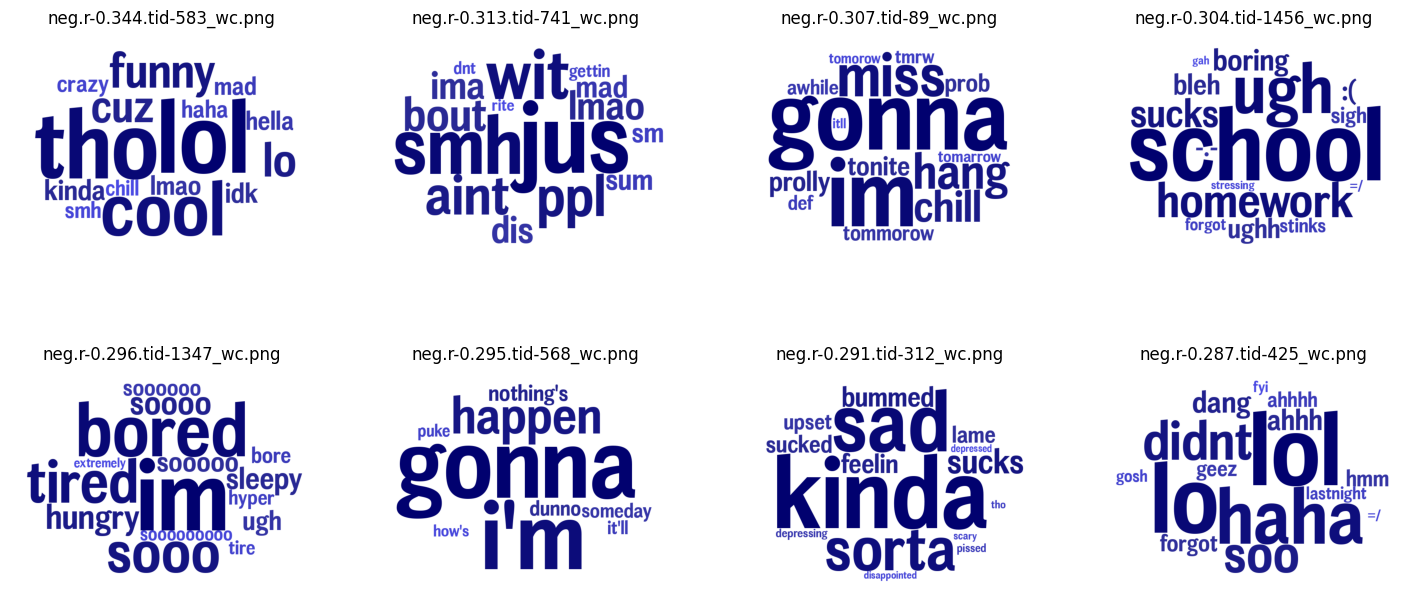

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_10/topics_age_gender_topic_tagcloud_wordclouds/age'
PREFIX = 'neg'
NUM_TOPICS = 8

print_wordclouds(WORDCLOUD_FOLDER, PREFIX, NUM_TOPICS)

And here the 8 most positively correlated ones (= older).      

Note the file names: correlation coefficients are ranging from r = .330 to .264

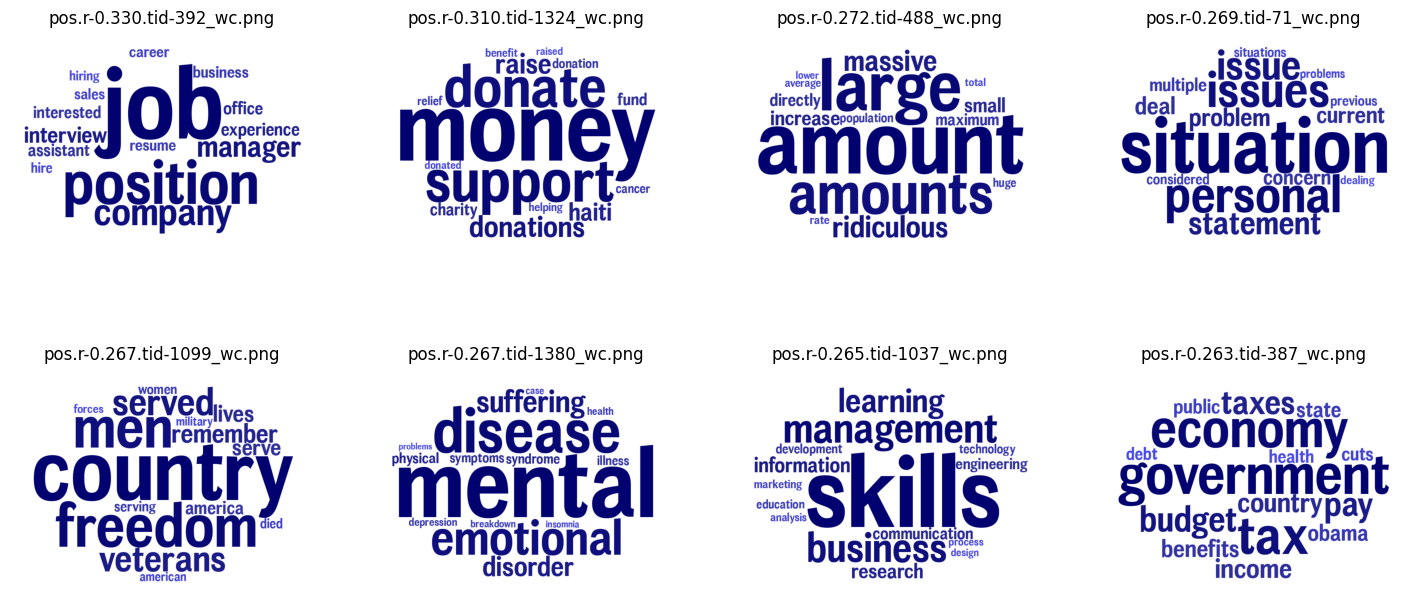

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_10/topics_age_gender_topic_tagcloud_wordclouds/age'
PREFIX = 'pos'
NUM_TOPICS = 8

print_wordclouds(WORDCLOUD_FOLDER, PREFIX, NUM_TOPICS)

You could now download the image files to your system and arrange them into panels that are grouped by themes, or otherwise look for language patterns.



## 6) Extracting and correlating word2vec clusters

LDA topics rely on **"semantic relatedness"** -- words occuring in similar contexts, so that "book" occurs with "reading".

_Alternatively,_ we can cluster down distances in the embedding space to get words that can occur in the same spot in similar sentences -- **substitutability**. If for some reason you'd like to extract and correlate these clusters, they are ready for you to use in `dlatk_lexica`. These clusters too behave like weighted dictionaries for us, and their word clouds are based on the same tables used to extract them. Let's use a set set of 2,000 word2vec embedding clusters contained in `dlatk_lexica.w2v_2000`.

Here is how we would extract them (it's just another weighted lexicon) -- requires the 1gram feature table first, as always. We have extracted it above in this tutorial, but here's the command for completeness.

In [ ]:
# database = 'dla_tutorial'
# msgs_table = 'msgs'

In [ ]:
# !dlatkInterface.py \
#    --corpdb {database} \
#    --corptable {msgs_table} \
#    --correl_field user_id \
#    --group_freq_thresh 500 \
#    --add_ngrams -n 1

Then we extract the embeddings features as follows. Remember the `--weighted_lexicon` flag here.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
w2v_2000_table = "w2v_2000"

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --group_freq_thresh 500 \
    --add_lex_table -l {w2v_2000_table} \
    --weighted_lexicon




-----
DLATK Interface Initiated: 2025-05-14 23:28:57
-----
Connecting to SQLite database: /content/sqlite_data/dla_tutorial
query: PRAGMA table_info(msgs)
SQL Query: DROP TABLE IF EXISTS feat$cat_w2v_2000_w$msgs$user_id$1gra
SQL Query: CREATE TABLE feat$cat_w2v_2000_w$msgs$user_id$1gra ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(10), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$cat_w2v_2000_w$msgs$user_id$1gra, column:group_id 


SQL Query: CREATE INDEX correl_field$cat_w2v_2000_w$msgs$user_id$1gra ON feat$cat_w2v_2000_w$msgs$user_id$1gra (group_id)


Creating index feature on table:feat$cat_w2v_2000_w$msgs$user_id$1gra, column:feat 


SQL Query: CREATE INDEX feature$cat_w2v_2000_w$msgs$user_id$1gra ON feat$cat_w2v_2000_w$msgs$user_id$1gra (feat)
WORD TABLE feat$1gram$msgs$user_id
10 out of 1000 group Id's processed; 0.01 complete
20 out of 1000 group Id's processed; 0.02 complete
30 out of 1000 group Id's processed; 0.03 complete
40 out

The above command created the feature table `feat$cat_w2v_2000_w$msgs$user_id$1gra`.

Now we try to correlate them with the outcomes as we always do. For the visualization in tagclouds, we use the *SAME* `w2v_2000` table that we used to extract the topics with (unlike topics).

Making the clouds will take 5 minutes.

In [ ]:
feat_w2v_2000_user = 'feat$cat_w2v_2000_w$msgs$user_id$1gra'
w2v_table = "w2v_2000"

OUTPUT_FOLDER = './output_tutorial_10/'
OUTPUT_NAME = 'w2v_2000_age_gender'

database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --group_freq_thresh 500 \
    --correlate --rmatrix --csv --sort \
    --outcome_table {outcomes_table} \
    --outcomes age gender \
    --feat_table '{feat_w2v_2000_user}' \
    --topic_tagcloud --make_topic_wordclouds \
    --topic_lexicon {w2v_table} \
    --tagcloud_colorscheme blue \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/logs.txt 2>&1

Similar to the topic correlations above, the word2vec correlations (both in the form of CSV and HTML) will be in `~/output_tutorial_10/w2v_correlations/` folder.

And the corresponding wordclouds in a subdirectory called `w2v_2000_age_gender_topic_tagcloud_wordclouds`.

Let's look at younger embedding clouds:

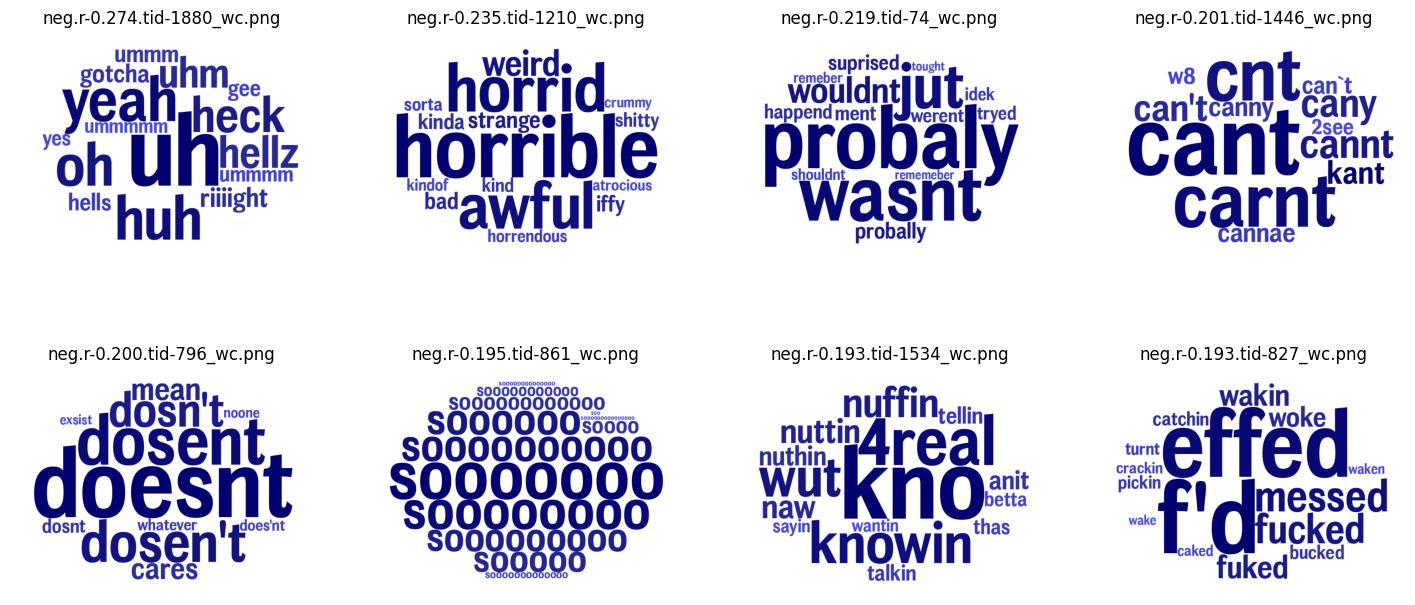

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_10/w2v_2000_age_gender_topic_tagcloud_wordclouds/age/'
PREFIX = 'neg'
NUM_TOPICS = 8

print_wordclouds(WORDCLOUD_FOLDER, PREFIX, NUM_TOPICS)

Here are the older ones:

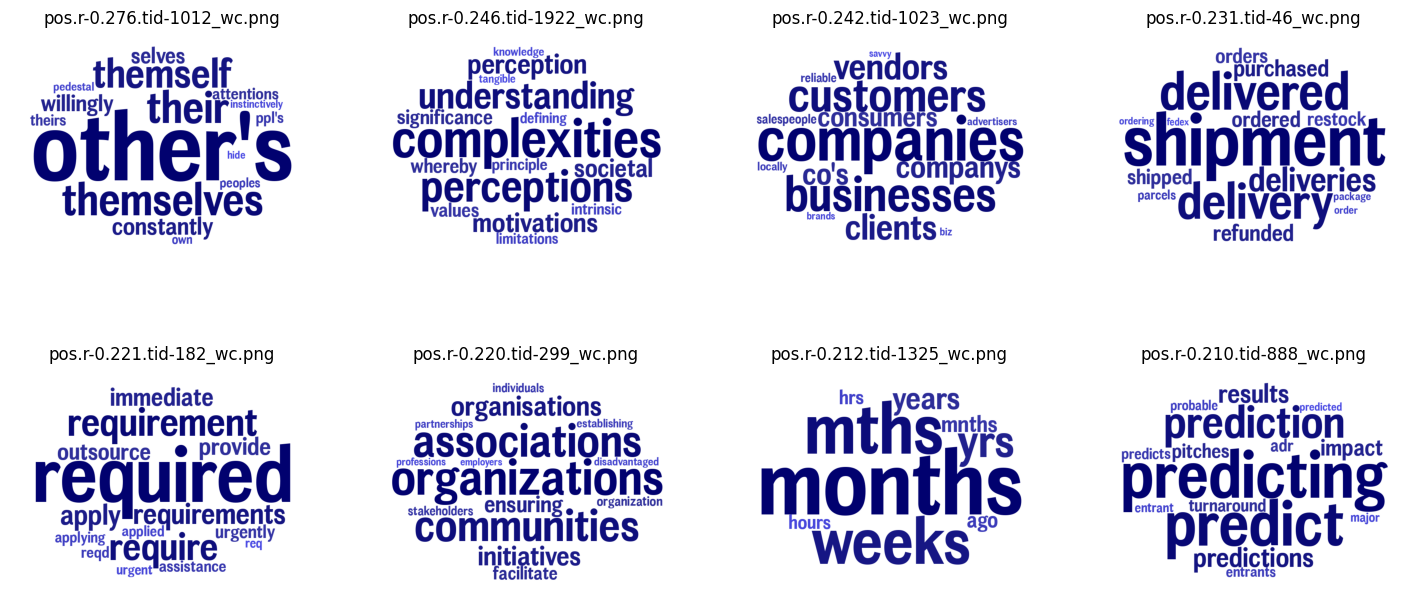

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_10/w2v_2000_age_gender_topic_tagcloud_wordclouds/age/'
PREFIX = 'pos'
NUM_TOPICS = 8

print_wordclouds(WORDCLOUD_FOLDER, PREFIX, NUM_TOPICS)



## 7) Sets of topics / embedding clusters in dlatk_lexica

The following clusters are ready for you to use in dlatk_lexica

**LDA Topics**  
* 500 topics trained on about ~14M Facebook statuses from 2009-2011 - `fb22_all_500t_cp` and `fb22_all_500t_freq`
* 2000 topics trained on about ~14M Facebook statuses from 2009-2011 (used in this tutorial) - `fb2000_cp` and `fb2000_freq_t50ll`

**Word2vec embeddings**  
100 to 2,000 dimensional embedding clusters, build on Twitter (100 million words, so roughly 10m Tweets) with [gensim](https://radimrehurek.com/gensim/)
* `w2v_100`
* `w2v_500`
* `w2v_1000`
* `w2v_2000`

**Choices for wordcloud colors (`--tagcloud_colorscheme COLOR`)**  
* blue [used in this tutorial]
* red
* redblue -- prints positively correlated clouds as red and negatively correlated clouds as blue.
* bluered -- prints positively correlated clouds as blue and negatively correlated clouds as red
* red-random.
* multi -- like wordclouds, and the dafault if no colorscheme is specified. Avoid this choice to avoid confusion of what color in topics mean (random) vs. 1to3gram wordclouds (frequency).



## 8) Worked example: Imporing and exploring topic feature tables in R

We've already did this on the fly above, let's see here in more detail how to import the topic feature table into R and do some plotting with topic feature tables.

Our goal is to plot a `school` topic and a `family` topic over age -- how does that sound?

Ok, let's get the top 4 topics to which most of the occurrences of "school" and "family" have been mapped to. We check that in the frequency table: we are looking for topics in which school and family are highly prevalent (carry a lot of weight within the topic).

If we did this as a real analysis for publication, we would first want to shortlist our outcome table to those users with GFT > 500 at least, to keep R and DLATK consistent. We will skip this here, but see Tutorial 07 for a reminder (extract 1grams, merge meta features onto outcome table, shortlist outcome table).

In [ ]:
database = 'dlatk_lexica'
topics_freq_table = 'fb2000_freq_t50ll'

In [ ]:
%sql dlatk_lexica_engine

In [ ]:
%%sql

SELECT *
FROM {{topics_freq_table}}
WHERE (term = "family") OR (term = "school")
ORDER BY weight DESC
LIMIT 5;

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

id,term,category,weight
5645,school,1378,38107.0
65056,family,123,34676.0
73305,school,1295,32128.0
69275,school,263,22253.0
49702,school,890,19554.0


So these are the topics to which most of the occurrences of "school" and "family" have been mapped to.

Let's use topic `1378` for school words, and `123` for family words.

Let's just confirm what the rest of the content of the topics is, using our query from a previous section:

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING category LIKE '1378' OR category LIKE '123';

Running query in 'sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4'

category,top_words
123,"family, friends, reunion, guy, members, member, addition, extended, newest, abc"
1378,"school, high, college, grad, musical, primary, middle, drama, career, graduated"


```
🐬🐬🐬
SET @num := 0, @type := '';

SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {topics_freq_table}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10
GROUP BY category
HAVING category LIKE "1378" OR category LIKE "123";
🐬🐬🐬
```

These look like good topics -- school and family are the leading words in them, and they are semantically coherent.

⚠️  Before we proceed, here's code to load the `%%R` line magic and set up if you need it again!

Putting it here, but skip this if you just used the R code in section 4!

In [ ]:
%reload_ext rpy2.ipython

# this is equivalent to install.packages() but much faster!!
!apt-get update -qq
!apt-get install -y r-cran-rsqlite r-cran-ggthemes r-cran-reshape2 r-cran-psych

# constructs the pathname
database_path = f"sqlite_data/{database}.db"
database_path

In [ ]:
%%R  -i database_path

library(tidyverse)
library(ggthemes)
library(reshape2)
library(psych)

source('./psych290_data/helper_files/psych290RcodeV1.R')

library(DBI)
library(RSQLite)

db_con <- dbConnect(RSQLite::SQLite(), dbname = database_path)
dbExecute(db_con, "PRAGMA encoding = 'UTF-8';")

We'll continue our analysis of the above 4 topics against the outcome table. So, let's import the respective topic features and `outcomes` tables into R.

<h4> 💻👩‍💻

The clever `-i var_name` syntax on load of the `%%R` cell magic inserts our Python variables into the R environment. Nifty!

In [ ]:
# define your tables!
feat_topics_table = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'
outcomes_table = 'outcomes'

In [ ]:
%%R -i feat_topics_table -i outcomes_table

sql <- sprintf('SELECT *
                FROM %s
                WHERE (feat = "123") OR (feat = "1378") OR (feat = "_intercept")',
                feat_topics_table) #this assembles the SQL query to get the feature table rows for these topics

feat_topic <- dbGetQuery(db_con, sql)

sql <- sprintf('SELECT * FROM %s', outcomes_table) #same as paste0()
outcomes <- outcomes <- dbGetQuery(db_con, sql)

Next, we'll inspect these tables. Remember our friendly `checkDf2()` function from HW7.

In [ ]:
%R head(outcomes)

,user_id,gender,age,occu,sign,is_indunk,is_student,is_education,is_technology,wordcount
1,3991108,1,17,indUnk,Leo,1,NA,NA,NA,615
2,3417138,1,25,Communications-Media,Taurus,0,0,NA,NA,4360
3,3673414,0,14,Student,Scorpio,0,1,NA,NA,1622
4,3361075,1,16,Student,Capricorn,0,1,NA,NA,810
5,4115327,1,14,indUnk,Libra,1,NA,NA,NA,8744
6,3549541,1,16,Student,Gemini,0,1,NA,NA,7452


In [ ]:
%R checkDf2(outcomes)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,user_id,0,1,28451,4325889,0,1000,1000
2,gender,0,1,0,1,502,1000,2
3,age,0,1,13,48,0,1000,26
4,occu,0,0,,,,,
5,sign,0,0,,,,,
6,is_indunk,0,1,0,1,642,1000,2
7,is_student,0,0,,,,,
8,is_education,0,0,,,,,
9,is_technology,0,0,,,,,
10,wordcount,0,1,419,365311,0,1000,917


This is a table in wide format with 1,000 rows -- kewl.

In [ ]:
%R checkDf2(feat_topic)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,id,0,1,684,1969607,0,2965,2965
2,group_id,0,1,28451,4325889,0,2965,1000
3,feat,0,0,,,,,
4,value,0,1,1,1575,0,2965,230
5,group_norm,0,1,4.69073425394211e-09,1,0,2965,1962


This is a table in long format with 2965 rows (in any checkDf output row, look at nonNA + NA = total number of rows).

Note that the `feat` column of `feat_topic` contains `123`, `1378` whereas `group_norm` contains their relative frequency. We now need to convert the table into "wide" format.

Previously, we've used the `importFeat()` function to transform the long-sparse table into "wide format" and add missing 0s to the sparse representation. For topic feature tables the process is the same, but R will stumble over the features being just numbers -- it doesn't like that for column names.

<h2> ⚠️🤓 importFeatTopics() <h2>

So, we use the function `importFeatTopics()` from the same script which will handle the name conversion of columns ("T1", "T2", ... for topics 1,2, ...). Let's have a quick look to remind ourselves that the dataframe loks like, then checkDf it.

💡 Don't forget the %R line magic vs %%R cell magic formatting trick! (`%R` is prettier!)

In [ ]:
%R feat_topic <- importFeatTopics(feat_topic)
%R head(feat_topic)

,group_id,T_intercept,T123,T1378
1,28451,1.0,0.000033,3.608892e-07
2,174357,1.0,0.000233,3.912576e-05
3,216833,1.0,0.000091,1.637548e-04
4,317581,1.0,0.000095,7.653474e-05
5,446275,1.0,0.000293,5.620816e-05
6,450169,1.0,0.000230,7.770841e-04


In [ ]:
%R checkDf2(feat_topic)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,group_id,0,1,28451,4325889,0,1000,1000
2,T_intercept,0,1,1,1,0,1000,1
3,T123,0,1,0,0.00363801167116369,15,1000,984
4,T1378,0,1,0,0.00325738425466584,20,1000,979


Note that we thanks to the _intercept feature, every user is represented for both topics (1000 rows!), with 0's where necessary (thanks to importTopicFeat()). Without pulling the intercept feature, we would have had 3 users who did not use either topic, and would have been missing them from this table.

For any further analysis against the outcomes, we need to merge the `feat_topic` and the `outcomes` table. Let's do that.

In [ ]:
%%R

OT <- merge(x=outcomes, y=feat_topic, by.x='user_id', by.y='group_id')

Let's plot one of the topics, say `1378` (the school topic), against `age`.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'




(`stat_smooth()`). 

(`geom_point()`). 



In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


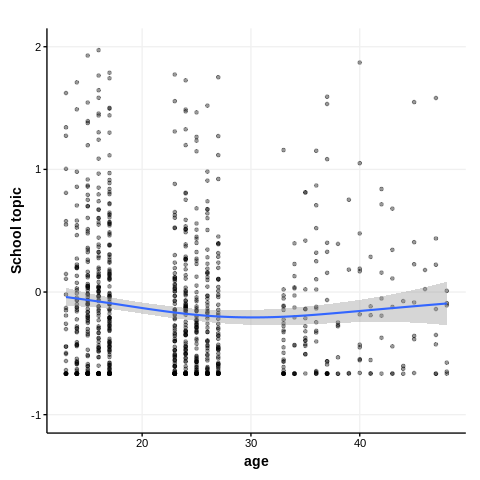

In [ ]:
%%R

ggplot(
    data=OT,
    aes(x=age, y=scale(T1378))) +
geom_point(alpha = .4) +
geom_smooth() +
theme_Publication() +
ylab("School topic") +
ylim(-1,2)

Look like it's going down (slightly.) BTW, we z-scored the group_norms for ease of interpretation.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'



(`stat_smooth()`). 

(`geom_point()`). 



In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


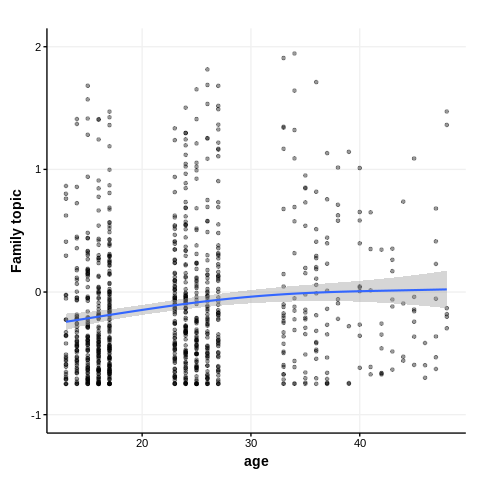

In [ ]:
%%R

ggplot(
    data=OT,
    aes(x=age, y=scale(T123))) +
geom_point(alpha = .4) +
geom_smooth() +
theme_Publication() +
ylab("Family topic") +
ylim(-1,2)

Family is going up -- the world makes sense.

## ‼️ **Save your database and/or output files** ‼️

Let's save all this work into as a new database file in your GDrive `sqlite_databases` folder!

In [ ]:
database = 'dla_tutorial'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'dla_tutorial.db' has been copied to your Google Drive.


We generated a lot of output in this tutorial! Here's how you can save it to your Drive if you want to!

In [ ]:
OUTPUT_FOLDER = './output_tutorial_10'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f -r {OUTPUT_FOLDER} "/content/drive/MyDrive/"

print(f"✅ '{OUTPUT_FOLDER}' has been copied to your Google Drive.")

Mounted at /content/drive
✅ './output_tutorial_10' has been copied to your Google Drive.
